This notebook lays out the model training process for ConvLSTM, including loading the data, hyperparameter setting, and customizing the loss function.

The ConvLSTM implementation is from [GeoTorchAI](https://kanchanchy.github.io/geotorchai/index.html) for experimentation. The code for training the ConvLSTM is adapted from [here](https://kanchanchy.github.io/geotorchai/coding_examples.html). See [here](https://kanchanchy.github.io/geotorchai/installation.html) for instructions on how to install GeoTorchAI.

Refer to `scripts/run.py` for the streamlined code.

In [130]:
import os
import time
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
from geotorchai.models.grid import ConvLSTM

import matplotlib.pyplot as plt
import seaborn as sns

# autoreload modules when code is changed
%load_ext autoreload
%autoreload 2

# load ImageFolder.py from scripts folder
import sys
sys.path.append('../scripts/')
from image_folder import ImageFolder, ImageDataset
from loss_functions import SSIMLoss, PhaseFieldLoss

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initialize device with GPU
In order to perform deep learning with GPU, we need to check whether GPU is available at first. We will initialize the device with GPU if it is available. Otherwise, CPU will be used as the default device.

In [2]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    return device

device = get_device()
print(device)

mps


## Define method for calculating three types of errors: MSE, MAE, RMSE

In [4]:
def compute_errors(preds, y_true):
    pred_mean = preds[:, 0:2]
    diff = y_true - pred_mean

    mse = np.mean(diff ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(diff))

    return mse, mae, rmse             

## Define method for calculating validation loss

In [5]:
# Write a function to use plt to save the model predictions
def save_pred_plots(outputs, Y_batch, batch_num, epoch, num_samples):
    for i in range(num_samples):
        try:
            plt.figure(figsize=(8, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(outputs[i, len_history - 1, 0, :, :].cpu().data.numpy(), cmap='gray')
            plt.axis('off')
            plt.title("Predicted")
            plt.subplot(1, 2, 2)
            plt.imshow(np.squeeze(Y_batch[i, 0, :, :].cpu().data.numpy()), cmap='gray')
            plt.axis('off')
            plt.title("Ground Truth")

            # save figure to model_dir
            plt.savefig(model_dir + f"/plots/val_batch_{batch_num}_sample_{i}_{epoch}.png")
            # don't show plot
            plt.close()
        except:
            print(f"sample {i} failed to plot")
            continue

def get_validation_loss(model, val_generator, criterion, device, len_history, e):
    model.eval()
    mean_loss = []
    for i, sample in enumerate(val_generator):
        X_batch = sample["X_data"].type(torch.FloatTensor).to(device)
        Y_batch = sample["Y_data"].type(torch.FloatTensor).to(device)

        outputs = model(X_batch)
        if type(criterion) == SSIMLoss:
            loss = criterion(outputs[:, len_history - 1:len_history, :, :, :], Y_batch).item()
        elif type(criterion) == nn.MSELoss:
            loss = criterion(outputs, Y_batch).item()
        mean_loss.append(loss)
        
        if (e + 1) % 10 == 0:
            # save outputs to plot later
            save_pred_plots(outputs, Y_batch, i, epoch=e+1, num_samples=batch_size)

    mean_loss = np.mean(mean_loss)
    return mean_loss

## Define model class

In [3]:
class GeoTorchConvLSTM(nn.Module):
    def __init__(self, input_size, hidden_dim, num_layers):
        super().__init__()
        self.lstm = ConvLSTM(input_dim=input_size, 
                             hidden_dim=hidden_dim, 
                             num_layers=num_layers)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        return lstm_out

## Initialize parameters

In [4]:
# model parameters
input_dim = 1
input_width = 128
input_height = 128
hidden_layer_sizes = [256, 256, 1]
num_layers = len(hidden_layer_sizes)

# sequence lengths
len_history = 5
len_predict = 1

# training parameters
epoch_nums = 40
learning_rate = 0.002
batch_size = 4 #4
params = {'batch_size': batch_size, 'shuffle': False, 'drop_last':False, 'num_workers': 2}

# Create function that assigns model name to global variable
def set_model_name(name, initial_model_dir=None):
    global model_name, model_dir, model_checkpoint, initial_checkpoint
    model_name = name

    # Sets the model output directory
    checkpoint_dir = '../models/'
    model_name = name
    model_dir = checkpoint_dir + model_name
    model_checkpoint = model_dir + '/model.best.pth'
    model_dir_plots = model_dir + "/plots"
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(model_dir_plots, exist_ok=True)
    print(f"Model directory: {model_dir}")
    print(F"Model directory for plots: {model_dir_plots}")

    # For loading pretrained model if available
    if initial_model_dir != None:
        initial_checkpoint = initial_model_dir + '/model.best.pth'
        print(f"Initial model checkpoint directory: {initial_model_dir}")

    

## Load Data

In [102]:
# Set data paths
data_root = '../data/cracks_s_nb'
train_path = os.path.join(data_root, "train")
test_path = os.path.join(data_root, "test")
val_path = os.path.join(data_root, "val")

In [118]:
train = ImageFolder(root=train_path, transform=transforms.ToTensor())
test = ImageFolder(root=test_path, transform=transforms.ToTensor())
val = ImageFolder(root=val_path, transform=transforms.ToTensor())

train.set_sequential_representation(history_length=len_history, predict_length=len_predict)
test.set_sequential_representation(history_length=len_history, predict_length=len_predict)
val.set_sequential_representation(history_length=len_history, predict_length=len_predict)

train_generator = DataLoader(ImageDataset(train), **params)
test_generator = DataLoader(ImageDataset(test), **params)
val_generator = DataLoader(ImageDataset(val), **params)

In [10]:
train.__getitem__(0).shape

torch.Size([1, 128, 128])

In [5]:
def load_data(data_dir='../data/cracks_s_nb', resize_dim=None):
    global input_dim, input_width, input_height
    # Set data paths
    data_root = data_dir
    train_path = os.path.join(data_root, "train")
    test_path = os.path.join(data_root, "test")
    val_path = os.path.join(data_root, "val")
    
    train = ImageFolder(root=train_path, transform=transforms.ToTensor(), resize=resize_dim)
    test = ImageFolder(root=test_path, transform=transforms.ToTensor(), resize=resize_dim)
    val = ImageFolder(root=val_path, transform=transforms.ToTensor(), resize=resize_dim)

    train.set_sequential_representation(history_length=len_history, predict_length=len_predict)
    test.set_sequential_representation(history_length=len_history, predict_length=len_predict)
    val.set_sequential_representation(history_length=len_history, predict_length=len_predict)

    train_generator = DataLoader(ImageDataset(train), **params)
    test_generator = DataLoader(ImageDataset(test), **params)
    val_generator = DataLoader(ImageDataset(val), **params)
    
    input_dim = train.__getitem__(0).shape[0]
    input_width = train.__getitem__(0).shape[1]
    input_height = train.__getitem__(0).shape[2]
    
    # print(train.__getitem__(0).shape)
    
    return train_generator, test_generator, val_generator
    

## Define method for initializing model and perform training and testing

In [12]:
def createModelAndTrain(loss_fn, train_generator, test_generator, val_generator, LOAD_INITIAL=False):
    device = get_device()

    model = GeoTorchConvLSTM(input_dim, hidden_layer_sizes, num_layers)

    if LOAD_INITIAL:
        model.load_state_dict(torch.load(initial_checkpoint, map_location=lambda storage, loc: storage))

    loss_fn = loss_fn
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.to(device)
    loss_fn.to(device)

    min_val_loss = None
    for e in range(epoch_nums):
        for i, sample in enumerate(train_generator):
            X_batch = sample["X_data"].type(torch.FloatTensor).to(device)
            Y_batch = sample["Y_data"].type(torch.FloatTensor).to(device)

            # Forward pass
            outputs = model(X_batch)
            loss = loss_fn(outputs[:, len_history - 1:len_history, :, :, :], Y_batch)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        val_loss = get_validation_loss(model, val_generator, loss_fn, device, len_history, e)
        
        print('Epoch [{}/{}], Train Loss: {:.4f}'.format(e + 1, epoch_nums, loss.item()), 'Mean Val Loss:', val_loss)

        if min_val_loss == None or val_loss < min_val_loss:
            min_val_loss = val_loss
            torch.save(model.state_dict(), model_checkpoint)
            print('best model saved!')

    model.load_state_dict(torch.load(model_checkpoint, map_location=lambda storage, loc: storage))
    model.eval()
    rmse_list = []
    mse_list = []
    mae_list = []
    for i, sample in enumerate(test_generator):
        X_batch = sample["X_data"].type(torch.FloatTensor).to(device)
        Y_batch = sample["Y_data"].type(torch.FloatTensor).to(device)

        outputs = model(X_batch)
        mse, mae, rmse = compute_errors(outputs[:, len_history - 1:len_history, :, :, :].cpu().data.numpy(),
                                        Y_batch.cpu().data.numpy())

        rmse_list.append(rmse)
        mse_list.append(mse)
        mae_list.append(mae)
        
        # save plots
        for j in range(batch_size):
            try:
                plt.figure(figsize=(8, 4))
                plt.subplot(1, 2, 1)
                plt.imshow(outputs[j, len_history - 1, 0, :, :].cpu().data.numpy(), cmap='gray')
                plt.axis('off')
                plt.title("Predicted")
                plt.subplot(1, 2, 2)
                plt.imshow(np.squeeze(Y_batch[j, 0, :, :].cpu().data.numpy()), cmap='gray')
                plt.axis('off')
                plt.title("Ground Truth")
                # save figure to model_dir
                plt.savefig(model_dir + f"/plots/test_batch_{i}_sample_{i}_{epoch_nums}.png")
                # don't show plot
                plt.close()
            except:
                print(f"sample {j} failed to plot")
                continue

    rmse = np.mean(rmse_list)
    mse = np.mean(mse_list)
    mae = np.mean(mae_list)

    print("\n************************")
    print("Test ConvLSTM model with Crack Dataset:")
    print('Test mse: %.6f mae: %.6f rmse (norm): %.6f' % (
    mse, mae, rmse))

## Define loss functions

In [13]:
# Set loss functions
loss_mse = nn.MSELoss()
loss_ssim = SSIMLoss()
loss_phasefield = PhaseFieldLoss()

## Call model training and testing from main

In [61]:
# Pretrain the model on simple_line dataset
if __name__ == '__main__':
    try:
        resize_dim = (128, 128)
        train_generator, test_generator, val_generator = load_data('../data/simple_line', resize_dim=resize_dim)
        set_model_name(f'convlstm_mse_epoch{epoch_nums}_lr{learning_rate}_pretraining')
        createModelAndTrain(loss_mse, train_generator, test_generator, val_generator)
        # createModelAndTrain(loss_fn=loss_ssim)
        # createModelAndTrain(loss_fn=loss_phasefield)
    finally:
        # Clear the memory
        # torch.cuda.empty_cache()
        torch.mps.empty_cache()

torch.Size([1, 128, 128])
Model directory: ../models/convlstm_mse_epoch40_lr0.002_pretraining
Model directory for plots: ../models/convlstm_mse_epoch40_lr0.002_pretraining/plots


/Users/jy/Documents/GitHub/crack_forecasting/.conda/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4, 1, 1, 128, 128])) that is different to the input size (torch.Size([4, 5, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/40], Train Loss: 0.0021 Mean Val Loss: 0.004524396266788244
best model saved!
Epoch [2/40], Train Loss: 0.0022 Mean Val Loss: 0.004534464795142412
Epoch [3/40], Train Loss: 0.0021 Mean Val Loss: 0.004528167191892862
Epoch [4/40], Train Loss: 0.0021 Mean Val Loss: 0.0045284549705684185
Epoch [5/40], Train Loss: 0.0022 Mean Val Loss: 0.004537743981927633
Epoch [6/40], Train Loss: 0.0021 Mean Val Loss: 0.0045229108072817326
best model saved!
Epoch [7/40], Train Loss: 0.0021 Mean Val Loss: 0.004528488498181105
Epoch [8/40], Train Loss: 0.0021 Mean Val Loss: 0.004547072108834982
Epoch [9/40], Train Loss: 0.0021 Mean Val Loss: 0.004520191811025143
best model saved!
Epoch [10/40], Train Loss: 0.0021 Mean Val Loss: 0.004520082380622625
best model saved!
Epoch [11/40], Train Loss: 0.0021 Mean Val Loss: 0.0045356894843280315
Epoch [12/40], Train Loss: 0.0021 Mean Val Loss: 0.004520896356552839
Epoch [13/40], Train Loss: 0.0021 Mean Val Loss: 0.004523817449808121
Epoch [14/40], Train Los

torch.Size([1, 128, 128])
Model directory: ../models/convlstm_mse_epoch40_lr0.002_w_pretraining
Model directory for plots: ../models/convlstm_mse_epoch40_lr0.002_w_pretraining/plots
Initial model checkpoint directory: ../models/convlstm_mse_epoch40_lr0.002_pretraining


/Users/jy/Documents/GitHub/crack_forecasting/.conda/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4, 1, 1, 128, 128])) that is different to the input size (torch.Size([4, 5, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/jy/Documents/GitHub/crack_forecasting/.conda/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1, 1, 128, 128])) that is different to the input size (torch.Size([1, 5, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/40], Train Loss: 0.0011 Mean Val Loss: 0.004681976870275461
best model saved!
Epoch [2/40], Train Loss: 0.0009 Mean Val Loss: 0.003738809197854537
best model saved!
Epoch [3/40], Train Loss: 0.0004 Mean Val Loss: 0.0033103726052034358
best model saved!
Epoch [4/40], Train Loss: 0.0003 Mean Val Loss: 0.0036663473225556887
Epoch [5/40], Train Loss: 0.0003 Mean Val Loss: 0.003324551794391412
Epoch [6/40], Train Loss: 0.0002 Mean Val Loss: 0.0034500257327006413
Epoch [7/40], Train Loss: 0.0003 Mean Val Loss: 0.003109657742942755
best model saved!
Epoch [8/40], Train Loss: 0.0002 Mean Val Loss: 0.0032193664676294876
Epoch [9/40], Train Loss: 0.0002 Mean Val Loss: 0.003197282194518126
sample 1 failed to plot
sample 2 failed to plot
sample 3 failed to plot
Epoch [10/40], Train Loss: 0.0002 Mean Val Loss: 0.003198532638354943
Epoch [11/40], Train Loss: 0.0002 Mean Val Loss: 0.003099705594090315
best model saved!
Epoch [12/40], Train Loss: 0.0002 Mean Val Loss: 0.003263206955475303
Epo

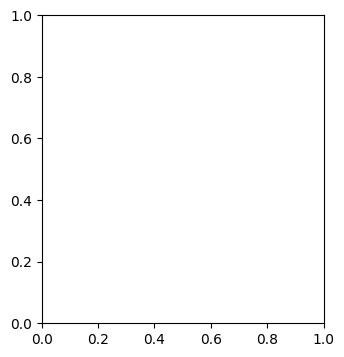

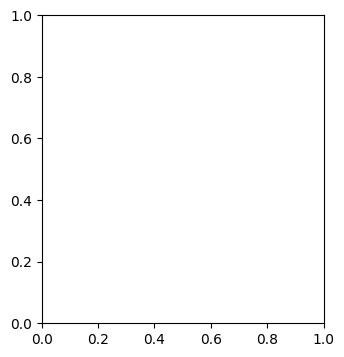

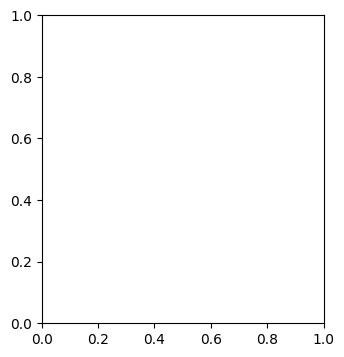

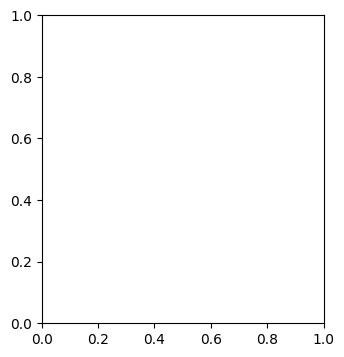

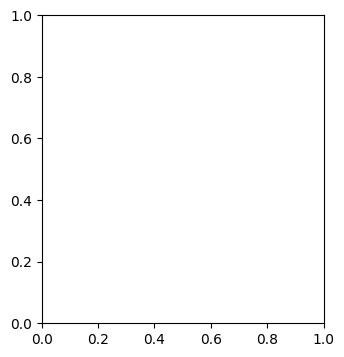

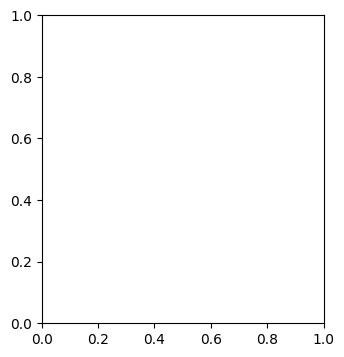

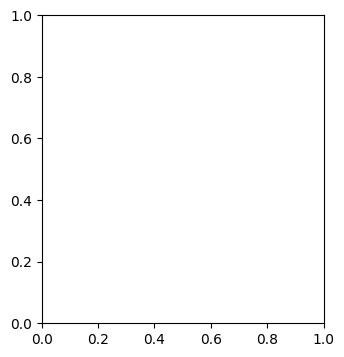

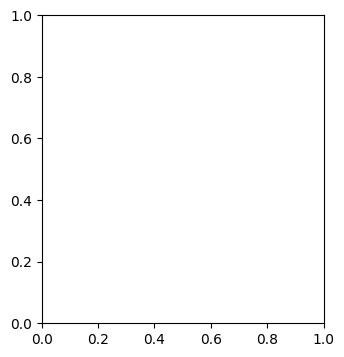

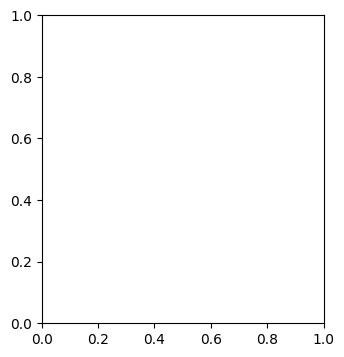

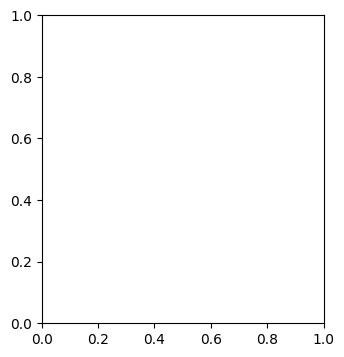

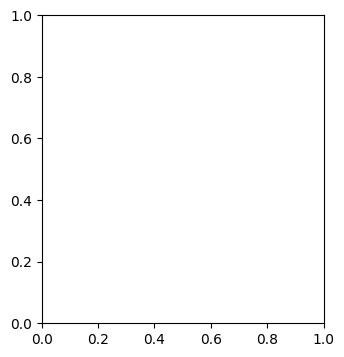

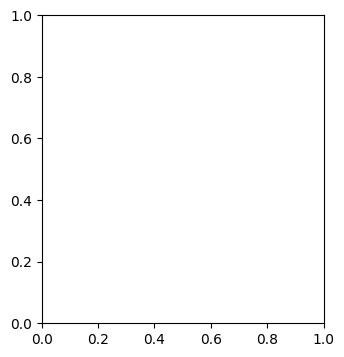

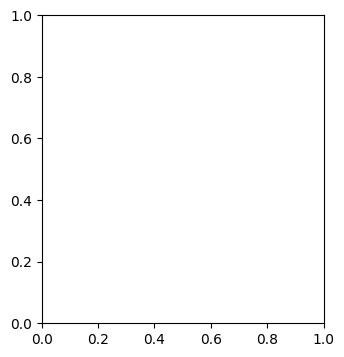

In [16]:
if __name__ == '__main__':
    try:
        train_generator, test_generator, val_generator = load_data()
        pretrained_model_dir = '../models/convlstm_mse_epoch40_lr0.002_pretraining'
        set_model_name(f'convlstm_mse_epoch{epoch_nums}_lr{learning_rate}_w_pretraining', initial_model_dir=pretrained_model_dir)
        createModelAndTrain(loss_mse, train_generator, test_generator, val_generator, LOAD_INITIAL=True)
    finally:
        # Clear the memory
        # torch.cuda.empty_cache()
        torch.mps.empty_cache()

# Visualize Predictions

In [6]:
# Load model from checkpoint file in models folder
def load_model(checkpoint):
    model = GeoTorchConvLSTM(input_dim, hidden_layer_sizes, num_layers)
    model.load_state_dict(torch.load(checkpoint))
    model.to(device)
    return model

model_simple_lines = load_model('../models/convlstm_mse_epoch40_lr0.002_pretraining/model.best.pth')
model_w_pretraining = load_model('../models/convlstm_mse_epoch40_lr0.002_w_pretraining/model.best.pth')
model_wo_pretraining = load_model('../models/convlstm_mse_epoch40_lr0.002/model.best.pth')

train_generator_sl, test_generator_sl, val_generator_sl = load_data('../data/simple_line', resize_dim=(128, 128))
train_generator, test_generator, val_generator = load_data()

In [7]:
# Write a function to use plt to show the model predictions
def show_predictions(model, test_generator, device, num_samples=5):
    model.eval()
    num_plotted = 0
    for i, sample in enumerate(test_generator):
        X_batch = sample["X_data"].type(torch.FloatTensor).to(device)
        Y_batch = sample["Y_data"].type(torch.FloatTensor).to(device)

        outputs = model(X_batch)
        batch_size = outputs.shape[0]

        for j in range(batch_size):
            if num_plotted < num_samples:
                try:
                    plt.figure(figsize=(8, 4))
                    plt.subplot(1, 2, 1)
                    plt.imshow(outputs[j, len_history - 1, 0, :, :].cpu().data.numpy(), cmap='gray')
                    plt.axis('off')
                    plt.title("Predicted")
                    plt.subplot(1, 2, 2)
                    plt.imshow(np.squeeze(Y_batch[j, 0, :, :].cpu().data.numpy()), cmap='gray')
                    plt.axis('off')
                    plt.title("Ground Truth")
                    plt.show()
                    num_plotted += 1
                except:
                    print(f"sample {j} failed to plot")
                    continue
            else:
                break
            
        if num_plotted >= num_samples:
            break

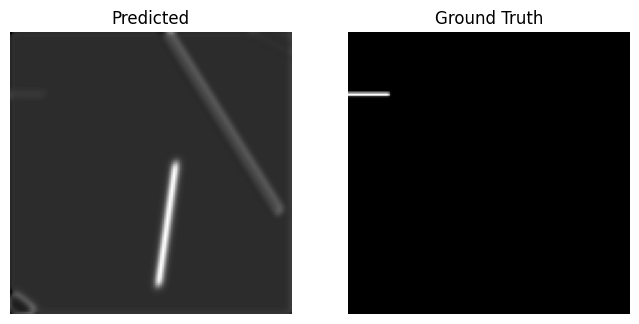

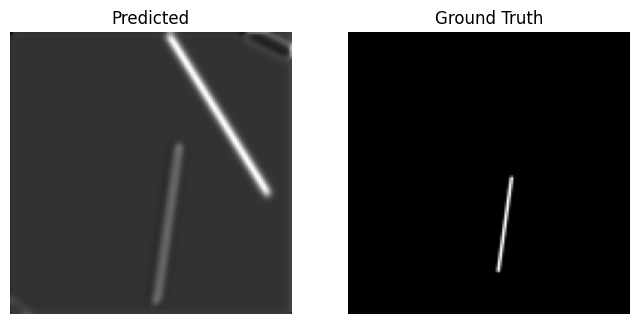

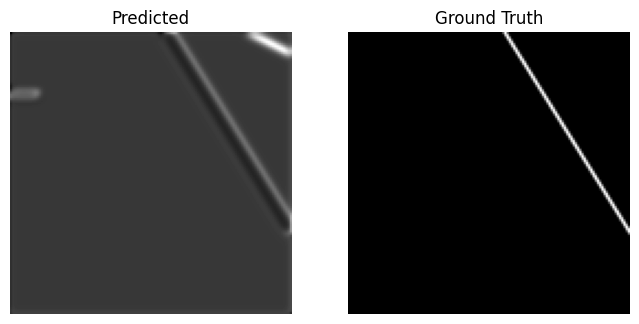

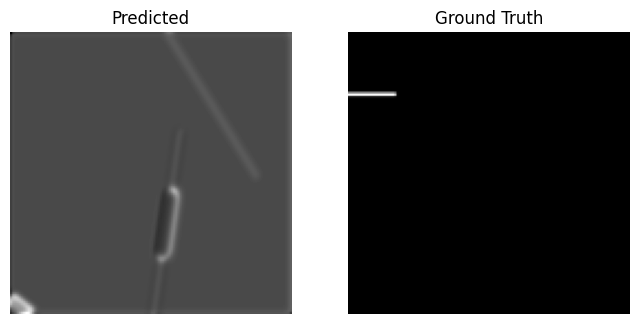

In [10]:
show_predictions(model_simple_lines, test_generator_sl, device, num_samples=4)

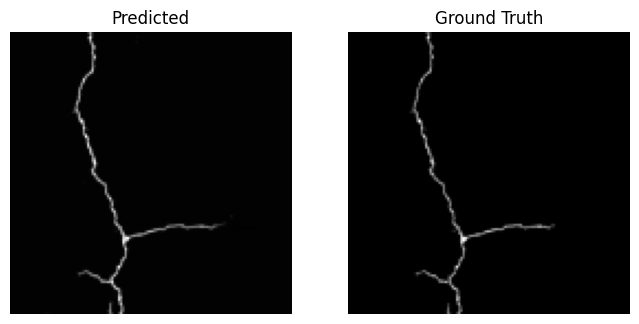

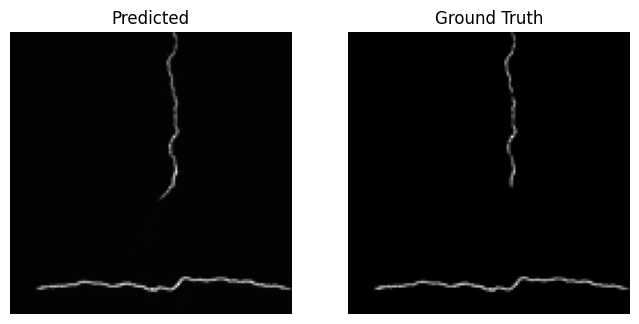

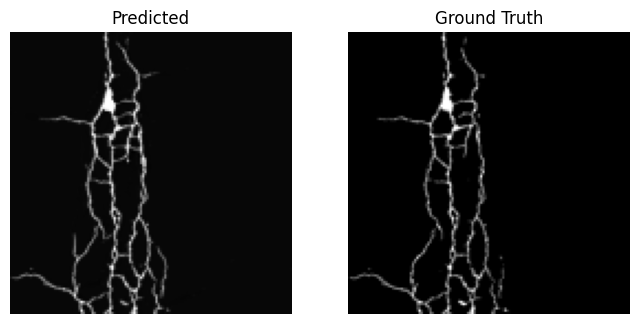

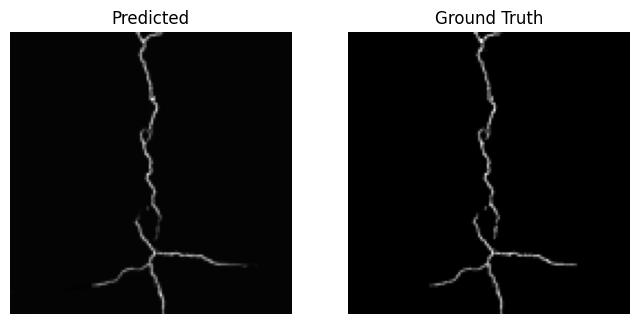

In [13]:
show_predictions(model_wo_pretraining, test_generator, device, num_samples=4)

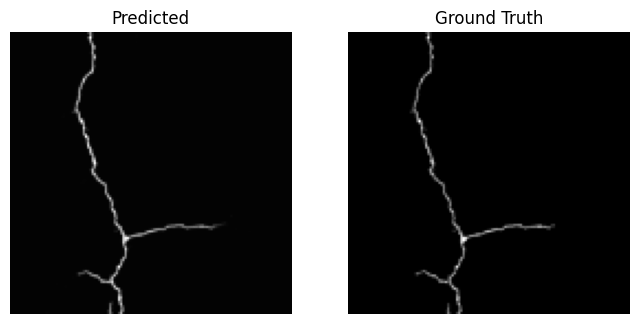

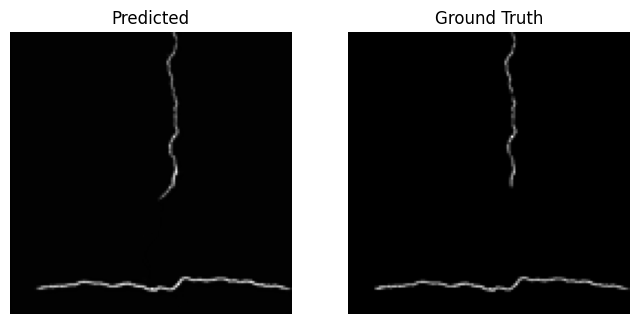

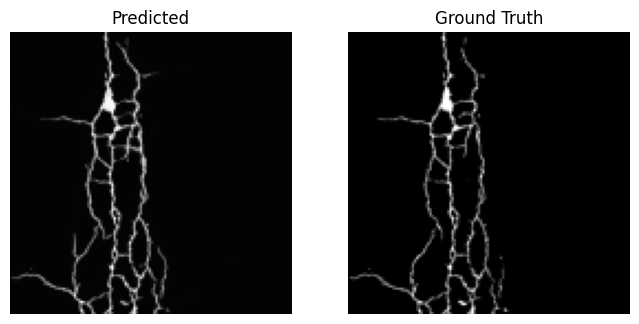

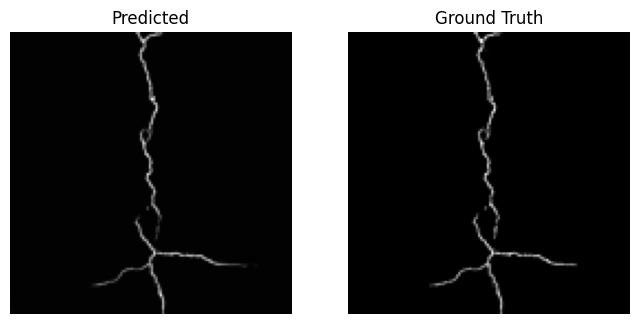

In [40]:
show_predictions(model_w_pretraining, test_generator, device, num_samples=4)

# Metrics

## 2-D correlation coefficient (2D-CC)

In [8]:
from scipy.signal import correlate2d

# define a function to calculate the 2-d correlation coefficient for all test samples
def correlation_coef(model, test_generator, device):
    model.eval()
    corr_coeff_list = []
    
    for i, sample in enumerate(test_generator):
        X_batch = sample["X_data"].type(torch.FloatTensor).to(device)
        Y_batch = sample["Y_data"].type(torch.FloatTensor).to(device)

        outputs = model(X_batch)
        batch_size = outputs.shape[0]

        # for each image in the batch, calculate the correlation coefficient
        for j in range(batch_size):
            corr_coeff = correlate2d(outputs[j, len_history - 1, 0, :, :].cpu().data.numpy(), 
                                    np.squeeze(Y_batch[j, 0, :, :].cpu().data.numpy()))
            corr_coeff_list.append(corr_coeff)
        
    return np.mean(corr_coeff_list)

In [11]:
cc_sl = correlation_coef(model_simple_lines, test_generator_sl, device)
print(f"Correlation coefficient for simple line dataset: {cc_sl}")

Correlation coefficient for simple line dataset: 0.12450707703828812


In [14]:
cc_wo_p = correlation_coef(model_wo_pretraining, test_generator, device)
print(f"Correlation coefficient for crack dataset without pretraining: {cc_wo_p}")

Correlation coefficient for crack dataset without pretraining: 0.6165270805358887


In [15]:
cc_w_p = correlation_coef(model_w_pretraining, test_generator, device)
print(f"Correlation coefficient for crack dataset with pretraining: {cc_w_p}")

Correlation coefficient for crack dataset with pretraining: 0.5922068357467651


## Structural similarity (SS)​​

In [21]:
from skimage.metrics import structural_similarity as ssim

def structural_sim(model, test_generator, device):
    model.eval()
    ssim_list = []
    
    for i, sample in enumerate(test_generator):
        X_batch = sample["X_data"].type(torch.FloatTensor).to(device)
        Y_batch = sample["Y_data"].type(torch.FloatTensor).to(device)

        outputs = model(X_batch)
        batch_size = outputs.shape[0]

        # for each image in the batch, calculate the correlation coefficient
        for j in range(batch_size):
            ss = ssim(outputs[j, len_history - 1, 0, :, :].cpu().data.numpy(), 
                      np.squeeze(Y_batch[j, 0, :, :].cpu().data.numpy()),
                      data_range=1.0)
            ssim_list.append(ss)
        
    return np.mean(ssim_list)

In [23]:
ss_sl = structural_sim(model_simple_lines, test_generator_sl, device)
print(f"Structural similarity for simple line dataset: {ss_sl}")

Structural similarity for simple line dataset: 0.6776892121335623


In [25]:
ss_wo_p = structural_sim(model_wo_pretraining, test_generator, device)
print(f"Structural similarity for crack dataset without pretraining: {ss_wo_p}")

Structural similarity for crack dataset without pretraining: 0.985084128269531


In [26]:
ss_w_p = structural_sim(model_w_pretraining, test_generator, device)
print(f"Structural similarity for crack dataset with pretraining: {ss_w_p}")

Structural similarity for crack dataset with pretraining: 0.9854581675463991


## Bhattacharyya distance (BD)
0 < BD < infinity, the lower the more similar the histograms are

In [31]:
import cv2

# initialize OpenCV methods for histogram comparison
OPENCV_METHODS = {
    "Correlation": cv2.HISTCMP_CORREL,
    "Chi-Squared": cv2.HISTCMP_CHISQR,
    "Intersection": cv2.HISTCMP_INTERSECT,
    "Bhattacharyya": cv2.HISTCMP_BHATTACHARYYA
}

# define a function to calculate the histogram comparison for all test samples
# Ref: https://pyimagesearch.com/2014/07/14/3-ways-compare-histograms-using-opencv-python/
def hist_comparison(model, test_generator, device, method="Bhattacharyya"):
    """
    method can be any of the following: 
    cv2.HISTCMP_CORREL: Computes the correlation between the two histograms.
    cv2.HISTCMP_CHISQR: Applies the Chi-Squared distance to the histograms.
    cv2.HISTCMP_INTERSECT: Calculates the intersection between two histograms.
    cv2.HISTCMP_BHATTACHARYYA: Bhattacharyya distance, used to measure the “overlap” between the two histograms.
    """
    model.eval()
    hc_list = []
    
    for i, sample in enumerate(test_generator):
        X_batch = sample["X_data"].type(torch.FloatTensor).to(device)
        Y_batch = sample["Y_data"].type(torch.FloatTensor).to(device)

        outputs = model(X_batch)
        batch_size = outputs.shape[0]

        # for each image in the batch, calculate the correlation coefficient
        for j in range(batch_size):
            h1 = cv2.calcHist([outputs[j, len_history - 1, 0, :, :].cpu().data.numpy()], [0], None, [256], [0, 256])
            h2 = cv2.calcHist([np.squeeze(Y_batch[j, 0, :, :].cpu().data.numpy())], [0], None, [256], [0, 256])
            hc = cv2.compareHist(h1, h2, OPENCV_METHODS[method])
            hc_list.append(hc)
        
    return np.mean(hc_list)

In [32]:
bd_sl = hist_comparison(model_simple_lines, test_generator_sl, device, method="Bhattacharyya")
print(f"Bhattacharyya distance for simple line dataset: {bd_sl}")

Bhattacharyya distance for simple line dataset: 0.0


In [33]:
bd_wo_p = hist_comparison(model_wo_pretraining, test_generator, device, method="Bhattacharyya")
print(f"Bhattacharyya distance for crack dataset without pretraining: {bd_wo_p}")

Bhattacharyya distance for crack dataset without pretraining: 0.003607748436235065


In [34]:
bd_w_p = hist_comparison(model_w_pretraining, test_generator, device, method="Bhattacharyya")
print(f"Bhattacharyya distance for crack dataset with pretraining: {bd_w_p}")

Bhattacharyya distance for crack dataset with pretraining: 0.0036077471063588385


## Histogram intersection distance (HID)​​
Counts the number of bins where the histograms overlap. This metric gives a value between 0 and the minimum number of samples in the two histograms, with 0 indicating no overlap and the maximum value indicating perfect overlap.

In [35]:
hid_sl = hist_comparison(model_simple_lines, test_generator_sl, device, method="Intersection")
print(f"Intersection for simple line dataset: {hid_sl}")

Intersection for simple line dataset: 16383.0


In [36]:
hid_wo_p = hist_comparison(model_wo_pretraining, test_generator, device, method="Intersection")
print(f"Intersection for crack dataset without pretraining: {hid_wo_p}")

Intersection for crack dataset without pretraining: 15416.669902912621


In [37]:
hid_w_p = hist_comparison(model_w_pretraining, test_generator, device, method="Intersection")
print(f"Intersection for crack dataset with pretraining: {hid_w_p}")

Intersection for crack dataset with pretraining: 904.5436893203884


## 3D visualization of relative error

In [150]:
# qt is for interactive plots
%matplotlib qt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# plot 3d visualization of relative error, comparing predicted image with ground truth
def plot_3d(model, test_generator, test, device, num_samples=5):
    model.eval()
    num_plotted = 0
    for i, sample in enumerate(test_generator):
        X_batch = sample["X_data"].type(torch.FloatTensor).to(device)
        Y_batch = sample["Y_data"].type(torch.FloatTensor).to(device)

        outputs = model(X_batch)
        batch_size = outputs.shape[0]

        for j in range(batch_size):
            if num_plotted < num_samples:
                try:
                    fig = plt.figure(figsize=(8, 4))
                    plt.rcParams['axes.facecolor'] = 'black'
                    plt.style.use("default")
                    ax = plt.axes(projection='3d')
                    x = np.arange(0, 128, 1)
                    y = np.arange(0, 128, 1)
                    X, Y = np.meshgrid(x, y)
                    Z = np.abs(outputs[j, len_history - 1, 0, :, :].cpu().data.numpy() - np.squeeze(Y_batch[j, 0, :, :].cpu().data.numpy()))
                    surf = ax.plot_surface(X, Y, Z, cmap=cm.magma, linewidth=0, antialiased=True,
                                           vmin=0, vmax=0.5)
                    fig.colorbar(surf, shrink=0.5, aspect=5)
                    
                    # figure out the corresponding filename for the sample
                    filename = test.__getitemseq__(i * batch_size + j)
                    plt.title(f"Relative error for {filename}")
                    
                    plt.show()
                    num_plotted += 1
                except:
                    print(f"sample {j} failed to plot")
                    continue
            else:
                break
            
        if num_plotted >= num_samples:
            break

In [151]:
test_sl = ImageFolder(root='../data/simple_line/test/', transform=transforms.ToTensor())
plot_3d(model_simple_lines, test_generator_sl, test_sl, device, num_samples=4)

In [149]:
test_crk = ImageFolder(root=test_path, transform=transforms.ToTensor())
plot_3d(model_wo_pretraining, test_generator, test_crk, device, num_samples=4)